In [41]:
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from PIL import Image
import numpy as np

In [42]:
episodes_dataset = tf.data.TFRecordDataset(
    "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-00000-of-00050",
    compression_type="GZIP"
)

In [43]:
raw_example = next(iter(episodes_dataset))

example = tf.train.Example()
example.ParseFromString(raw_example.numpy())

print("Features in the TFRecord example:")
for key in example.features.feature.keys():
    feature = example.features.feature[key]
    if feature.bytes_list.value:
        dtype = "bytes"
    elif feature.int64_list.value:
        dtype = "int64"
    elif feature.float_list.value:
        dtype = "float"
    else:
        dtype = "unknown"
    print(f"{key}: {dtype}")

Features in the TFRecord example:
episode_return: float
episode_idx: int64
observations: bytes
clipped_episode_return: float
unclipped_rewards: float
checkpoint_idx: int64
actions: int64
discounts: float
clipped_rewards: float


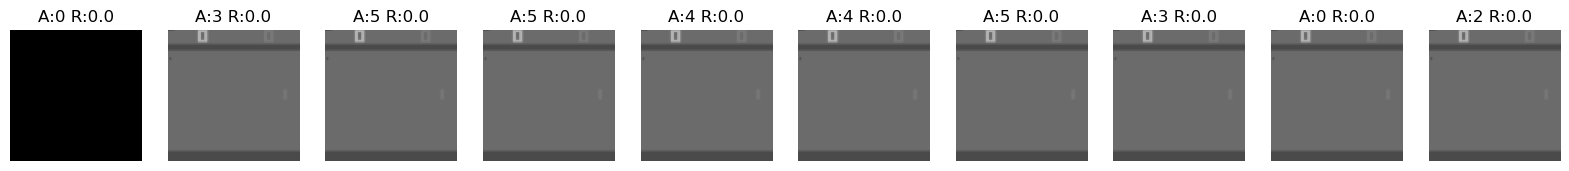

In [44]:
feature_description = {
    "observations": tf.io.VarLenFeature(tf.string),
    "actions": tf.io.VarLenFeature(tf.int64),
    "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def _parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)

    obs = tf.sparse.to_dense(parsed["observations"])
    actions = tf.sparse.to_dense(parsed["actions"])
    rewards = tf.sparse.to_dense(parsed["clipped_rewards"])

    img = tf.io.decode_image(obs[0], channels=3)
    return img, actions[0], rewards[0]

dataset_parsed = episodes_dataset.map(_parse_function)

plt.figure(figsize=(20, 4))
for i, (frame, action, reward) in enumerate(dataset_parsed.take(10)):
    plt.subplot(2, 10, i+1)
    plt.imshow(frame.numpy())
    plt.axis('off')
    plt.title(f"A:{action.numpy()} R:{reward.numpy():.1f}")
plt.show()

In [45]:
# !git clone https://github.com/Coluding/world-models.git

In [46]:
import sys
import os
local_repo_path = os.path.abspath(os.path.join(os.getcwd(), '../world-models'))
if local_repo_path not in sys.path:
    sys.path.append(local_repo_path)
from models.rssm import RSSM

import torch
from torch.utils.data import Dataset, DataLoader

In [48]:
feature_description = {
  "observations": tf.io.VarLenFeature(tf.string),
  "actions": tf.io.VarLenFeature(tf.int64),
  "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def parse_sequence(example_proto):
  parsed = tf.io.parse_single_example(example_proto, feature_description)
  obs = tf.sparse.to_dense(parsed["observations"])
  actions = tf.sparse.to_dense(parsed["actions"])
  rewards = tf.sparse.to_dense(parsed["clipped_rewards"])
  
  # Decode images and set explicit shape
  imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
  imgs.set_shape([None, None, None, 3])  # Set partial shape info
  
  # FIXED: Resize images to 64x64 to match encoder expectations
  imgs = tf.image.resize(imgs, [64, 64])
  imgs = tf.cast(imgs, tf.float32) / 255.0
  actions = tf.cast(actions, tf.int64)
  rewards = tf.cast(rewards, tf.float32)
  return imgs, actions, rewards

batch_size = 16
sequence_length = 50

episodes_dataset = tf.data.TFRecordDataset(
    "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-00000-of-00050",
    compression_type="GZIP"
)
dataset = episodes_dataset.map(parse_sequence)
dataset = dataset.filter(lambda imgs, actions, rewards: tf.shape(imgs)[0] >= sequence_length)

def extract_non_overlapping_sequences(imgs, actions, rewards):
    episode_length = tf.shape(imgs)[0]
    num_sequences = episode_length // sequence_length
    
    if num_sequences > 0:
        trimmed_length = num_sequences * sequence_length
        imgs_trimmed = imgs[:trimmed_length]
        actions_trimmed = actions[:trimmed_length]
        rewards_trimmed = rewards[:trimmed_length]
        
        imgs_sequences = tf.reshape(imgs_trimmed, [num_sequences, sequence_length, 64, 64, 3])
        actions_sequences = tf.reshape(actions_trimmed, [num_sequences, sequence_length])
        rewards_sequences = tf.reshape(rewards_trimmed, [num_sequences, sequence_length])
        
        return tf.data.Dataset.from_tensor_slices((imgs_sequences, actions_sequences, rewards_sequences))
    else:
        return tf.data.Dataset.from_tensor_slices((
            tf.zeros((0, sequence_length, 64, 64, 3), dtype=tf.float32),
            tf.zeros((0, sequence_length), dtype=tf.int64),
            tf.zeros((0, sequence_length), dtype=tf.float32)
        ))

dataset = dataset.map(extract_non_overlapping_sequences)
dataset = dataset.flat_map(lambda x: x)  # Flatten the nested datasets
dataset = dataset.batch(batch_size, drop_remainder=True)

(865, 64, 64, 3)
(865,)
(865,)


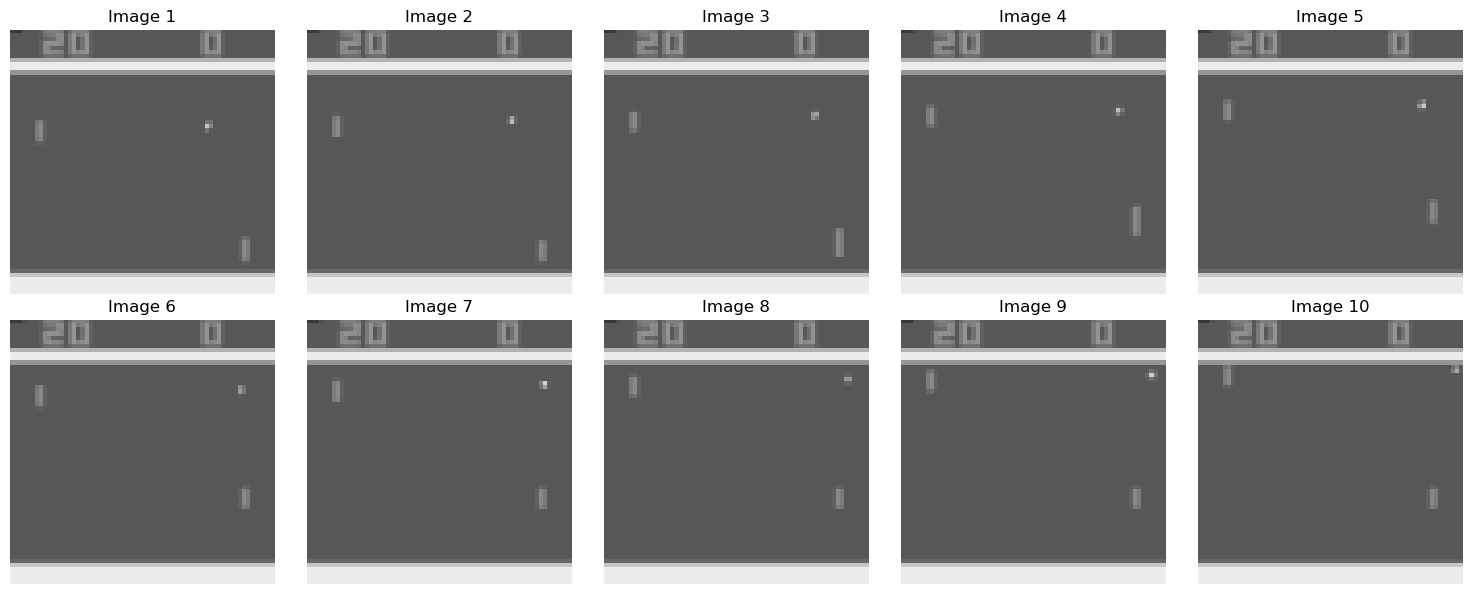

In [49]:

example = next(iter(episodes_dataset.take(1)))
imgs, actions, rewards = parse_sequence(example)

print(imgs.shape)
print(actions.shape)
print(rewards.shape)

last_ten_imgs = imgs[-10:]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(last_ten_imgs[i], vmin=0, vmax=1)
  ax.set_title(f"Image {i+1}")
  ax.axis("off")
plt.tight_layout()
plt.show()


In [50]:
for imgs, actions, rewards in dataset.take(1):
  print("imgs:", imgs.shape)
  print("actions:", actions.shape)
  print("rewards:", rewards.shape)

imgs: (16, 50, 64, 64, 3)
actions: (16, 50)
rewards: (16, 50)


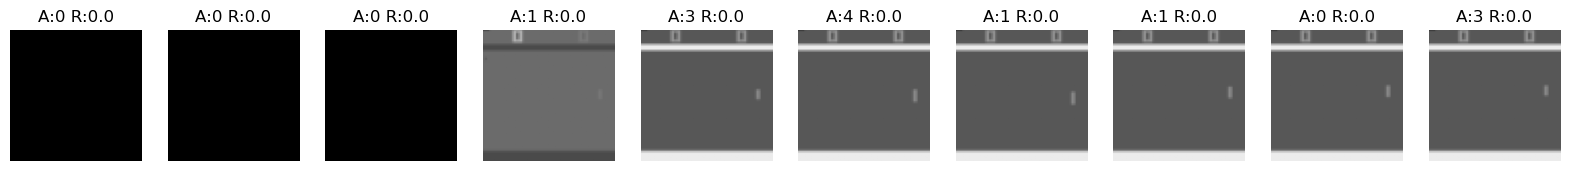

In [51]:
for imgs, actions, rewards in dataset.take(1):
  seq_imgs = imgs[0]
  seq_actions = actions[0]
  seq_rewards = rewards[0]

  plt.figure(figsize=(20, 4))
  for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(seq_imgs[i].numpy())
    plt.axis("off")
    plt.title(f"A:{seq_actions[i].numpy()} R:{seq_rewards[i].numpy():.1f}")
  plt.show()

In [52]:
def parse_sequence_for_inspection(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])
    imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
    print("Original image shape (before resizing):", imgs.shape)
    return imgs

example = next(iter(episodes_dataset.take(1)))
imgs = parse_sequence_for_inspection(example)

Original image shape (before resizing): (865, 84, 84, 3)


In [53]:
class AtariSequenceDataset(Dataset):
  def __init__(self, tf_dataset, num_batches):
    self.data = []
    for i, (imgs, actions, rewards) in enumerate(tf_dataset):
      if i >= num_batches:
        break
      self.data.append((
        imgs.numpy(), actions.numpy(), rewards.numpy()
      ))
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    imgs, actions, rewards = self.data[idx]
    imgs = torch.tensor(imgs, dtype=torch.float32)  # [seq, W, H, 3]
    actions = torch.tensor(actions, dtype=torch.long)  # [seq]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # [seq]
    return imgs, actions, rewards

In [54]:
num_batches = 100
atari_dataset = AtariSequenceDataset(dataset, num_batches)
dataloader = DataLoader(atari_dataset, batch_size=1, shuffle=True)

In [59]:
print("=== Dataset Size Information ===")
print(f"Number of batches: {len(atari_dataset)}")

sample_batch = atari_dataset[0]
imgs, actions, rewards = sample_batch
print(f"Shape of images in one batch: {imgs.shape}")
print(f"Shape of actions in one batch: {actions.shape}")
print(f"Shape of rewards in one batch: {rewards.shape}")

batch_size_in_dataset = imgs.shape[0]
sequence_length_per_example = imgs.shape[1]
total_examples = len(atari_dataset) * batch_size_in_dataset

print(f"\n=== Breakdown ===")
print(f"Sequences per batch: {batch_size_in_dataset}")
print(f"Frames per sequence: {sequence_length_per_example}")
print(f"Total sequences (examples): {total_examples}")
print(f"Total frames: {total_examples * sequence_length_per_example}")

print(f"\n=== Data Efficiency ===")
print(f"Original TF batch size: {batch_size}")
print(f"With sequence_length={sequence_length}, each ~900-frame episode gives us:")
print(f"  {900 // sequence_length} non-overlapping sequences")
print(f"  vs. 1 sequence with the old method")
print(f"  That's {900 // sequence_length}x more data per episode!")

=== Dataset Size Information ===
Number of batches: 100
Shape of images in one batch: torch.Size([16, 50, 64, 64, 3])
Shape of actions in one batch: torch.Size([16, 50])
Shape of rewards in one batch: torch.Size([16, 50])

=== Breakdown ===
Sequences per batch: 16
Frames per sequence: 50
Total sequences (examples): 1600
Total frames: 80000

=== Data Efficiency ===
Original TF batch size: 16
With sequence_length=50, each ~900-frame episode gives us:
  18 non-overlapping sequences
  vs. 1 sequence with the old method
  That's 18x more data per episode!


In [55]:
sample_batch = next(iter(dataset.take(1)))
sample_imgs = sample_batch[0]
print(f"Actual image shape in dataset: {len(sample_batch)}")
print(f"Actual image shape in dataset: {sample_imgs.shape}")
print(f"Individual image shape: {sample_imgs[0, 0].shape}")

Actual image shape in dataset: 3
Actual image shape in dataset: (16, 50, 64, 64, 3)
Individual image shape: (64, 64, 3)


In [56]:
from models.models import EncoderCNN, DecoderCNN, RewardModel
from models.rssm import RSSM
from models.dynamics import DynamicsModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

action_dim = 6
hidden_size = 1024
state_size = 32
encoder_embedding_dim = 1024
image_height, image_width = sample_imgs.shape[2], sample_imgs.shape[3]

encoder = EncoderCNN(
    in_channels=3, 
    embedding_dim=encoder_embedding_dim,
    input_shape=(image_height, image_width)
).to(device)

decoder = DecoderCNN(
    hidden_size=hidden_size, 
    state_size=state_size, 
    embedding_size=encoder_embedding_dim,
    use_bn=True, 
    output_shape=(3, image_height, image_width)
).to(device)

reward_model = RewardModel(hidden_size, state_size).to(device)

dynamics_model = DynamicsModel(
    hidden_dim=hidden_size,
    action_dim=action_dim,
    state_dim=state_size,
    embedding_dim=encoder_embedding_dim
).to(device)

rssm = RSSM(
    encoder, 
    decoder, 
    reward_model, 
    dynamics_model, 
    hidden_size, 
    state_size, 
    action_dim, 
    encoder_embedding_dim,
    device=device
)

optimizer = torch.optim.Adam(rssm.parameters(), lr=3e-4, weight_decay=1e-5)

print(f"Model created successfully:")
print(f"  - Action dim: {action_dim}")
print(f"  - Hidden size: {hidden_size}")
print(f"  - State size: {state_size}")
print(f"  - Embedding size: {encoder_embedding_dim}")
print(f"  - Image shape: (3, {image_height}, {image_width})")

total_params = sum(p.numel() for p in rssm.parameters() if p.requires_grad)
print(f"  - Total parameters: {total_params:,}")

Using device: cuda
Model created successfully:
  - Action dim: 6
  - Hidden size: 1024
  - State size: 32
  - Embedding size: 1024
  - Image shape: (3, 64, 64)
  - Total parameters: 22,010,757


# Modified Trainer for Dataset Usage

Instead of using an Agent that collects data from an environment, we'll create a modified Trainer that can work directly with our preprocessed Atari dataset.

In [ ]:
from tqdm import tqdm
import math

class AtariTrainer:
    def __init__(self, rssm: RSSM, dataloader, optimizer, device):
        self.rssm = rssm
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.device = device

    def train_batch(self, imgs: torch.Tensor, actions: torch.Tensor, rewards: torch.Tensor, iteration: int, save_images: bool=False):
        """
        Train on a single batch from the dataset
        Args:
            imgs: (batch_size, seq_len, height, width, channels)
            actions: (batch_size, seq_len)
            rewards: (batch_size, seq_len)
        """
        batch_size, seq_len = imgs.shape[0], imgs.shape[1]
        
        imgs = imgs.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        
        actions = torch.nn.functional.one_hot(actions, self.rssm.action_dim).float()
        
        # (batch_size, seq_len, H, W, C) -> (batch_size*seq_len, C, H, W)
        imgs_reshaped = imgs.reshape(-1, *imgs.shape[2:]).permute(0, 3, 1, 2).contiguous()
        
        encoded_obs = self.rssm.encoder(imgs_reshaped)
        encoded_obs = encoded_obs.reshape(batch_size, seq_len, -1)
        
        # Generate RSSM rollout
        rollout = self.rssm.generate_rollout(actions, obs=encoded_obs)
        hiddens, prior_states, posterior_states, prior_means, prior_logvars, posterior_means, posterior_logvars = rollout
        
        # Reconstruct observations
        hiddens_reshaped = hiddens.reshape(batch_size * seq_len, -1)
        posterior_states_reshaped = posterior_states.reshape(batch_size * seq_len, -1)
        
        decoded_obs = self.rssm.decoder(hiddens_reshaped, posterior_states_reshaped)
        decoded_obs = decoded_obs.reshape(batch_size, seq_len, *imgs.shape[-3:])
        
        # Predict rewards
        reward_params = self.rssm.reward_model(hiddens, posterior_states)
        reward_mean, reward_logvar = torch.chunk(reward_params, 2, dim=-1)
        
        # Clamp reward logvar to prevent extreme values
        reward_logvar = torch.clamp(reward_logvar, min=-10, max=10)
        reward_std = torch.exp(0.5 * reward_logvar) + 1e-6
        reward_dist = torch.distributions.Normal(reward_mean, reward_std)
        predicted_rewards = reward_dist.rsample()
        
        # Calculate losses
        reconstruction_loss = torch.nn.functional.mse_loss(decoded_obs, imgs)
        
        prior_std = torch.exp(0.5 * prior_logvars) + 1e-6
        posterior_std = torch.exp(0.5 * posterior_logvars) + 1e-6
        prior_dist = torch.distributions.Normal(prior_means, prior_std)
        posterior_dist = torch.distributions.Normal(posterior_means, posterior_std)
        kl_loss = torch.distributions.kl_divergence(posterior_dist, prior_dist).mean()
        
        reward_loss = torch.nn.functional.mse_loss(predicted_rewards, rewards.unsqueeze(-1))
        
        total_loss = reconstruction_loss + kl_loss + reward_loss
        
        # Optimization step
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.rssm.parameters(), 1.0)
        self.optimizer.step()
        
        # Optional visualization
        if save_images:
            self._visualize(imgs, decoded_obs, rewards, predicted_rewards, 
                          batch_idx=0, seq_idx=0, iterations=iteration, grayscale=False)
        
        return total_loss.item(), reconstruction_loss.item(), kl_loss.item(), reward_loss.item()
    
    def train(self, num_epochs):
        """Train the model for specified number of epochs"""
        self.rssm.train()
        
        global_step = 0
        last_loss = float("inf")
        
        for epoch in range(num_epochs):
            epoch_losses = []
            
            progress_bar = tqdm(self.dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
            
            for batch_idx, (imgs, actions, rewards) in enumerate(progress_bar):
                # Remove extra batch dimension from dataloader
                imgs = imgs.squeeze(0)
                actions = actions.squeeze(0)
                rewards = rewards.squeeze(0)
                
                total_loss, recon_loss, kl_loss, reward_loss = self.train_batch(
                    imgs, actions, rewards, global_step, save_images=(global_step % 100 == 0)
                )
                
                # Skip this batch if we got invalid losses
                if any(math.isinf(loss) or math.isnan(loss) for loss in [total_loss, recon_loss, kl_loss, reward_loss]):
                    print(f"Skipping batch {batch_idx} due to invalid loss values")
                    continue
                
                epoch_losses.append(total_loss)
                
                if total_loss < last_loss:
                    self.rssm.save("rssm_best.pth")
                    last_loss = total_loss
                
                progress_bar.set_postfix({
                    'Total Loss': f'{total_loss:.4f}',
                    'Recon': f'{recon_loss:.4f}',
                    'KL': f'{kl_loss:.4f}',
                    'Reward': f'{reward_loss:.4f}'
                })
                
                global_step += 1
            
            avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
            print(f"Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")
            
            if epoch % 5 == 0:
                self.rssm.save(f'rssm_checkpoint_epoch_{epoch+1}.pth')
    
    def _visualize(self, obs, decoded_obs, rewards, predicted_rewwards, batch_idx, seq_idx, iterations: int, grayscale: bool = True):
        obs = obs[batch_idx, seq_idx: seq_idx + 3]
        decoded_obs = decoded_obs[batch_idx, seq_idx: seq_idx + 3]

        rewards = rewards[batch_idx, seq_idx: seq_idx + 3]
        predicted_rewards = predicted_rewwards[batch_idx, seq_idx: seq_idx + 3]

        obs = obs.cpu().detach().numpy()
        decoded_obs = decoded_obs.cpu().detach().numpy()
        
        rewards = rewards.cpu().detach().numpy()
        predicted_rewards = predicted_rewards.cpu().detach().numpy()

        fig, axs = plt.subplots(3, 2, figsize=(10, 12))
        axs[0][0].imshow(obs[0, ..., 0], cmap="gray" if grayscale else None)
        axs[0][0].set_title(f"Iteration: {iterations} -- Reward: {rewards[0]:.4f}")
        axs[0][0].axis("off")
        axs[0][1].imshow(decoded_obs[0, ..., 0], cmap="gray" if grayscale else None)
        axs[0][1].set_title(f"Pred. Reward: {predicted_rewards[0, 0]:.4f}")

        axs[0][1].axis("off")

        axs[1][0].imshow(obs[1, ..., 0], cmap="gray" if grayscale else None)
        axs[1][0].axis("off")
        axs[1][0].set_title(f"Reward: {rewards[1]:.4f} ")
        axs[1][1].imshow(decoded_obs[1, ..., 0], cmap="gray" if grayscale else None)
        axs[1][1].set_title(f"Pred. Reward: {predicted_rewards[1, 0]:.4f}")
        axs[1][1].axis("off")

        axs[2][0].imshow(obs[2, ..., 0], cmap="gray" if grayscale else None)
        axs[2][0].axis("off")
        axs[2][0].set_title(f"Reward: {rewards[2]:.4f}")
        axs[2][1].imshow(decoded_obs[2, ..., 0], cmap="gray" if grayscale else None)
        axs[2][1].set_title(f"Pred. Reward: {predicted_rewards[2, 0]:.4f}")
        axs[2][1].axis("off")

        plt.tight_layout()
        plt.show()

AtariTrainer created successfully!
Dataset size: 100 batches
Device: cuda
Model parameters: 22,010,757 total

 Starting training...
Training for 10 epochs...


Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

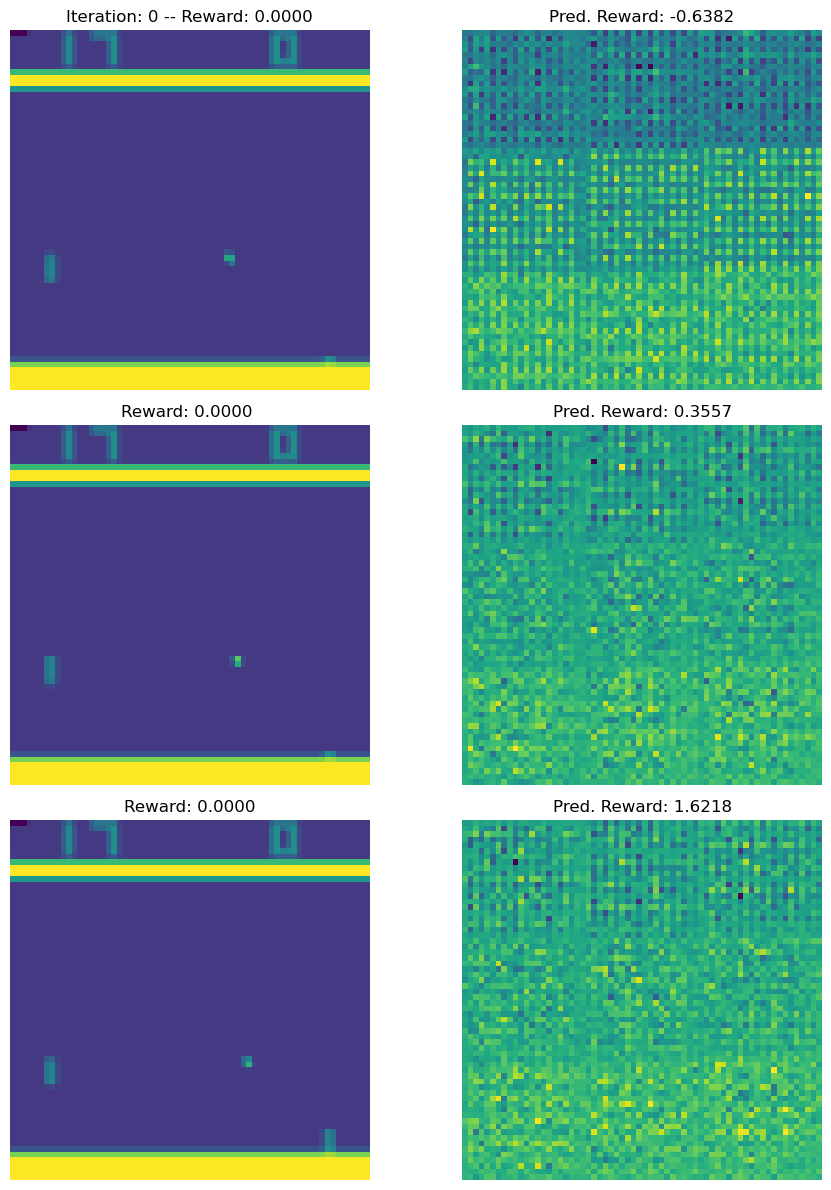

Epoch 1/10: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s, Total Loss=0.0358, Recon=0.0065, KL=0.0024, Reward=0.0268]


Epoch 1 completed. Average loss: 0.2364


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

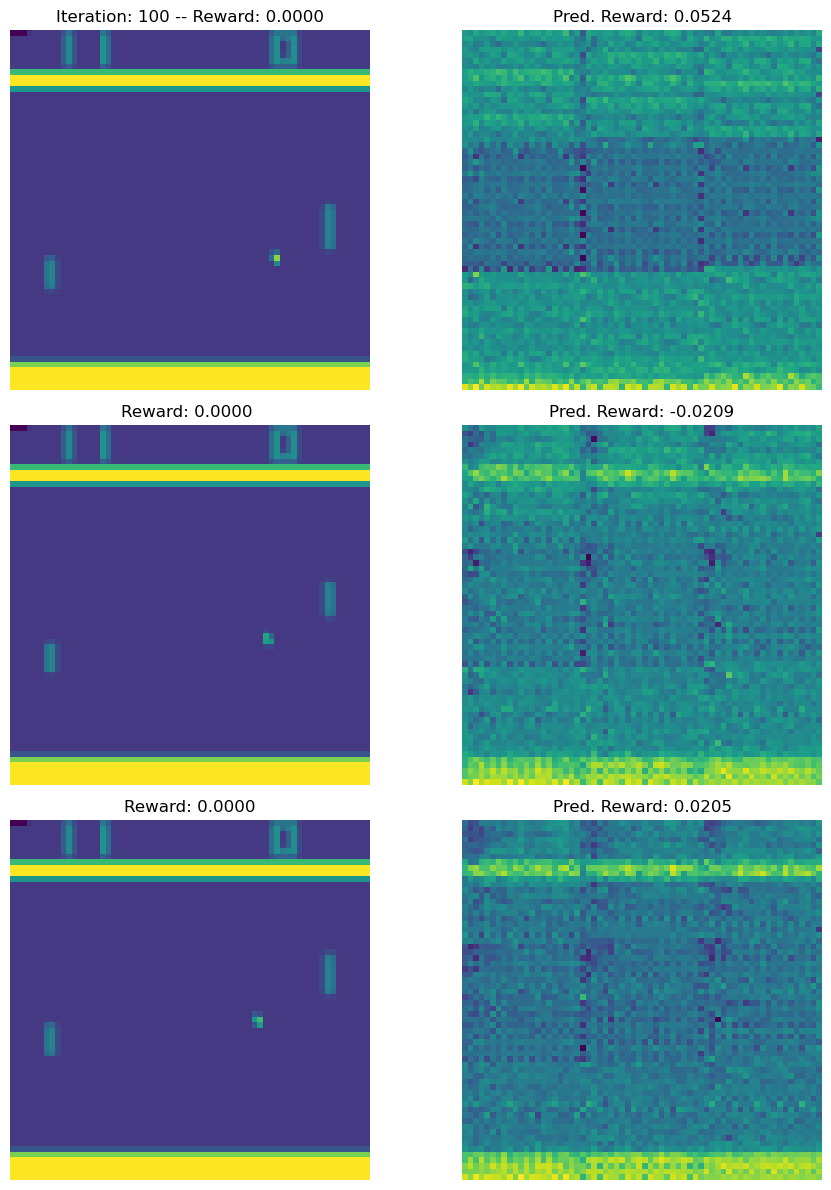

Epoch 2/10: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s, Total Loss=0.0229, Recon=0.0015, KL=0.0000, Reward=0.0214]    


Epoch 2 completed. Average loss: 5.5386


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

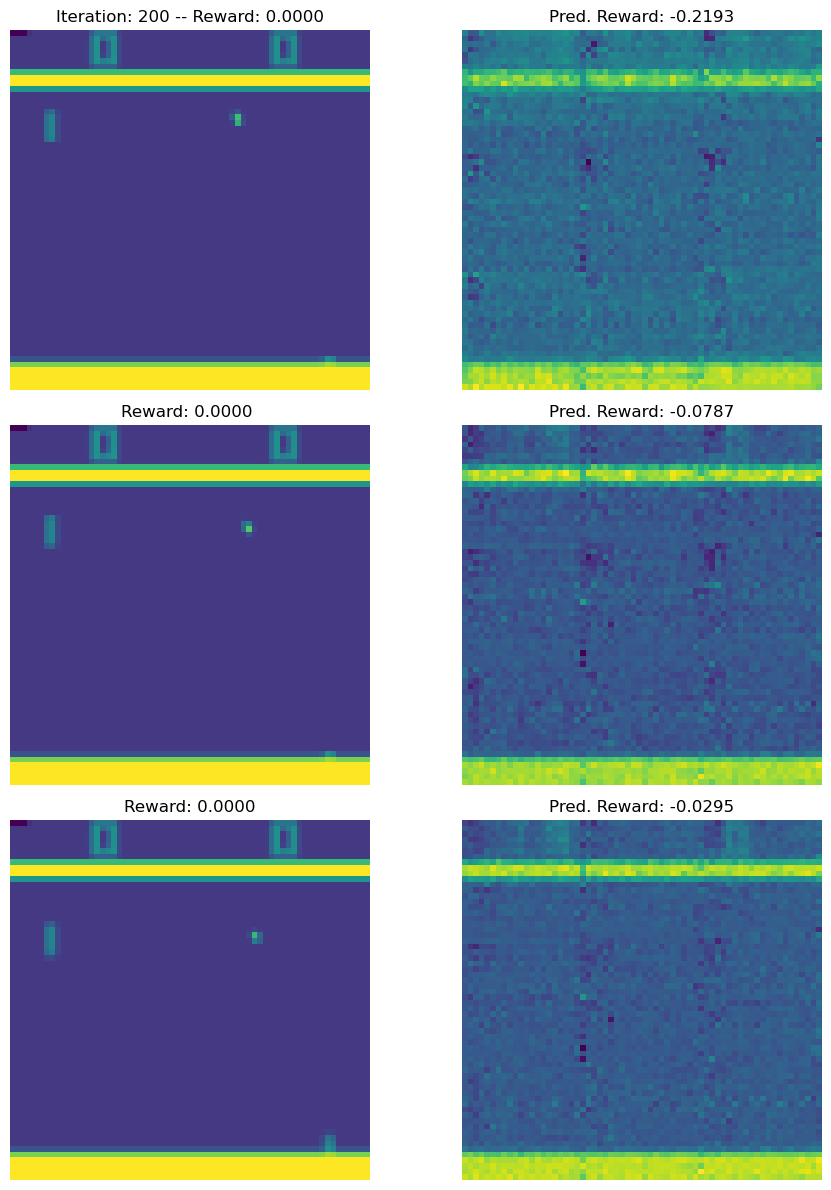

Epoch 3/10: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s, Total Loss=0.0255, Recon=0.0009, KL=0.0000, Reward=0.0246]                          


Epoch 3 completed. Average loss: 2890478059.5440


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

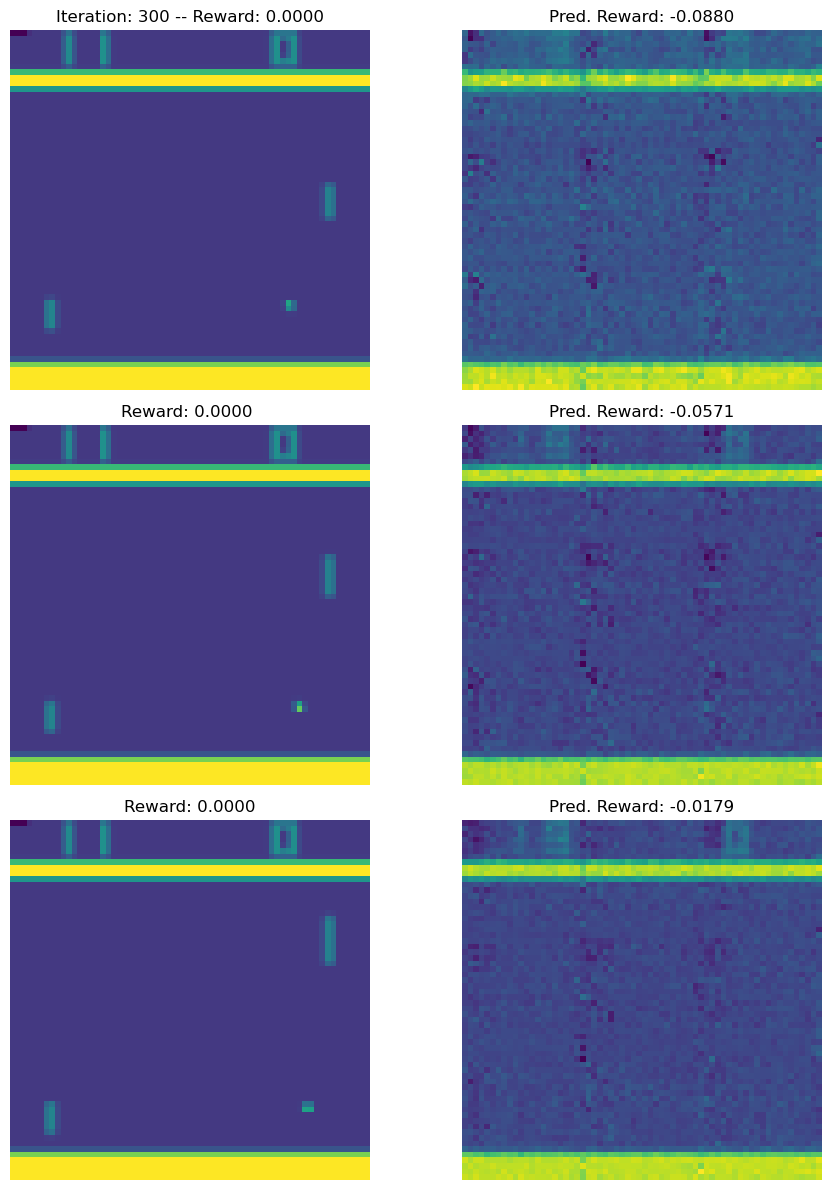

Epoch 4/10: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s, Total Loss=0.0223, Recon=0.0006, KL=0.0000, Reward=0.0217]                                                                   


Epoch 4 completed. Average loss: 52671292356005217118978048.0000


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

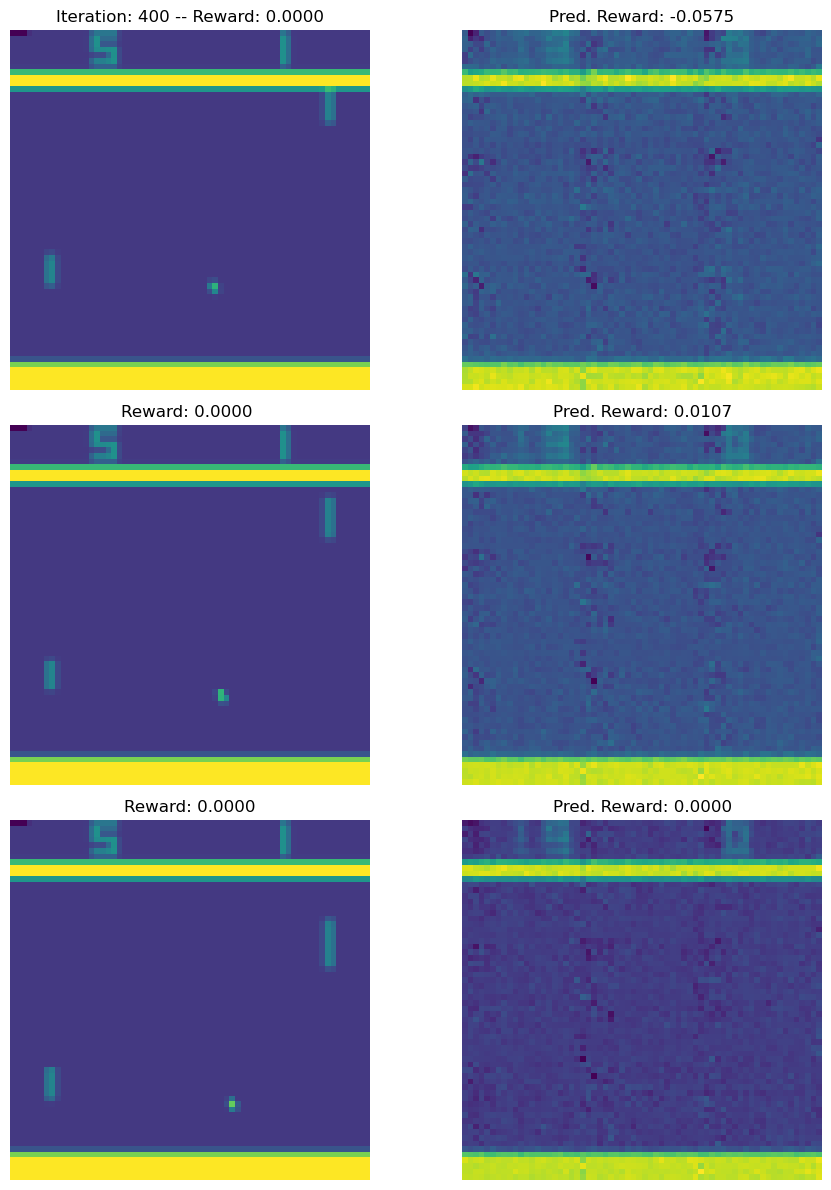

Epoch 5/10: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s, Total Loss=0.0201, Recon=0.0005, KL=0.0000, Reward=0.0196]                                                                  


Epoch 5 completed. Average loss: 53202298855171493000642560.0000


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

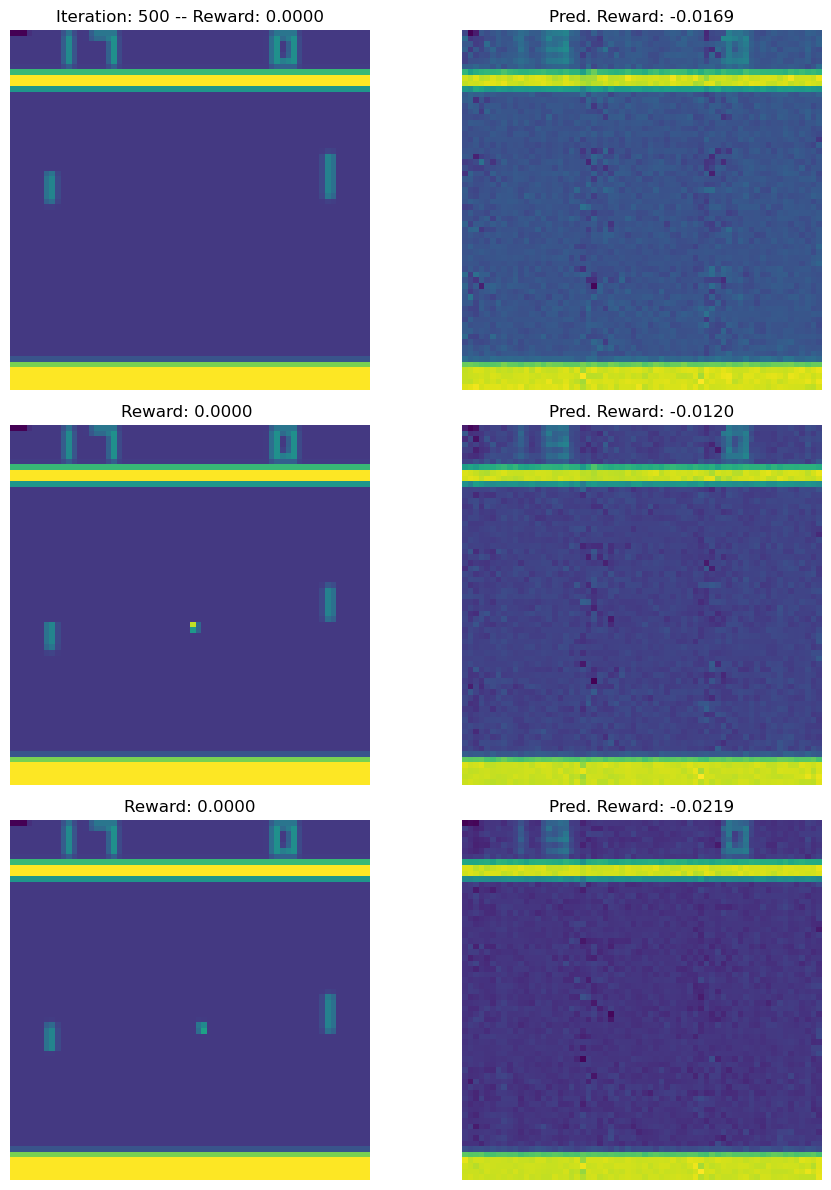

Epoch 6/10: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s, Total Loss=0.0228, Recon=0.0005, KL=0.0000, Reward=0.0223]                                                               


Epoch 6 completed. Average loss: 9133992396729311876349952.0000


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

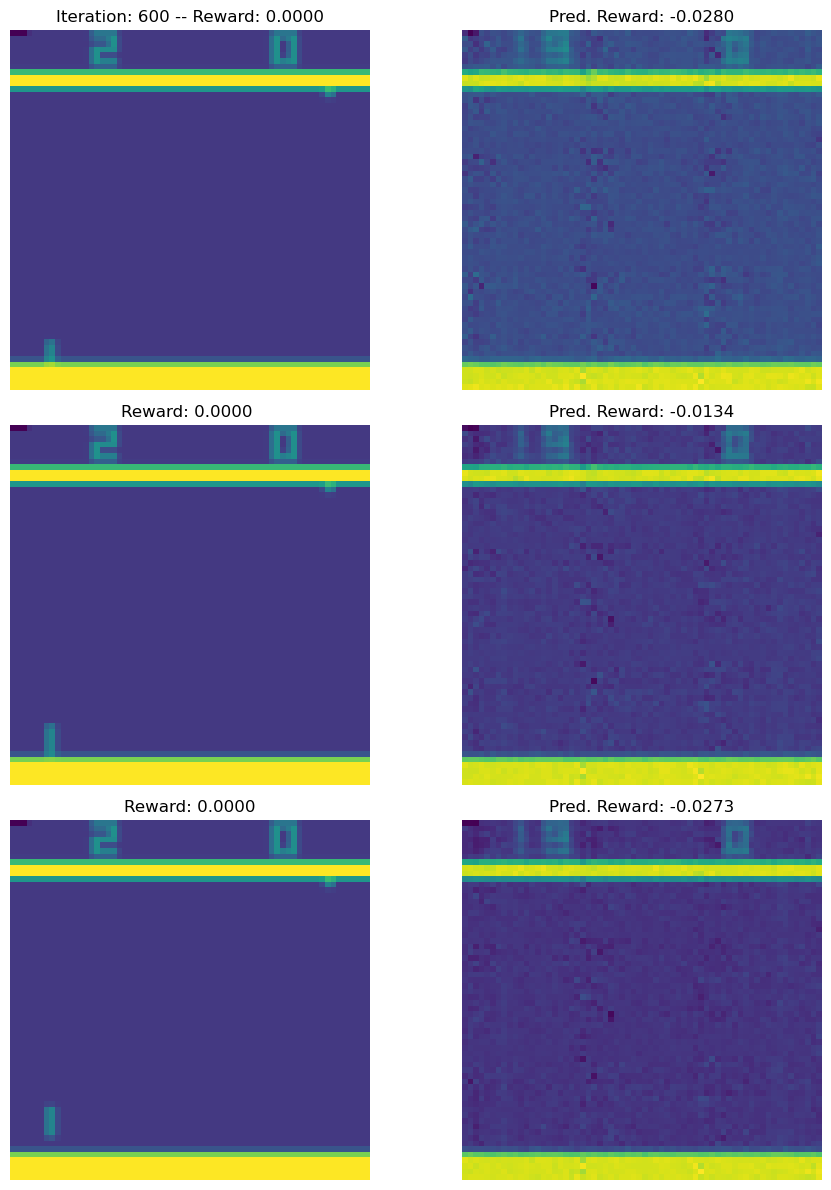

Epoch 7/10: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s, Total Loss=0.0212, Recon=0.0004, KL=0.0000, Reward=0.0207]                                                          


Epoch 7 completed. Average loss: 12425889658213278679040.0000


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

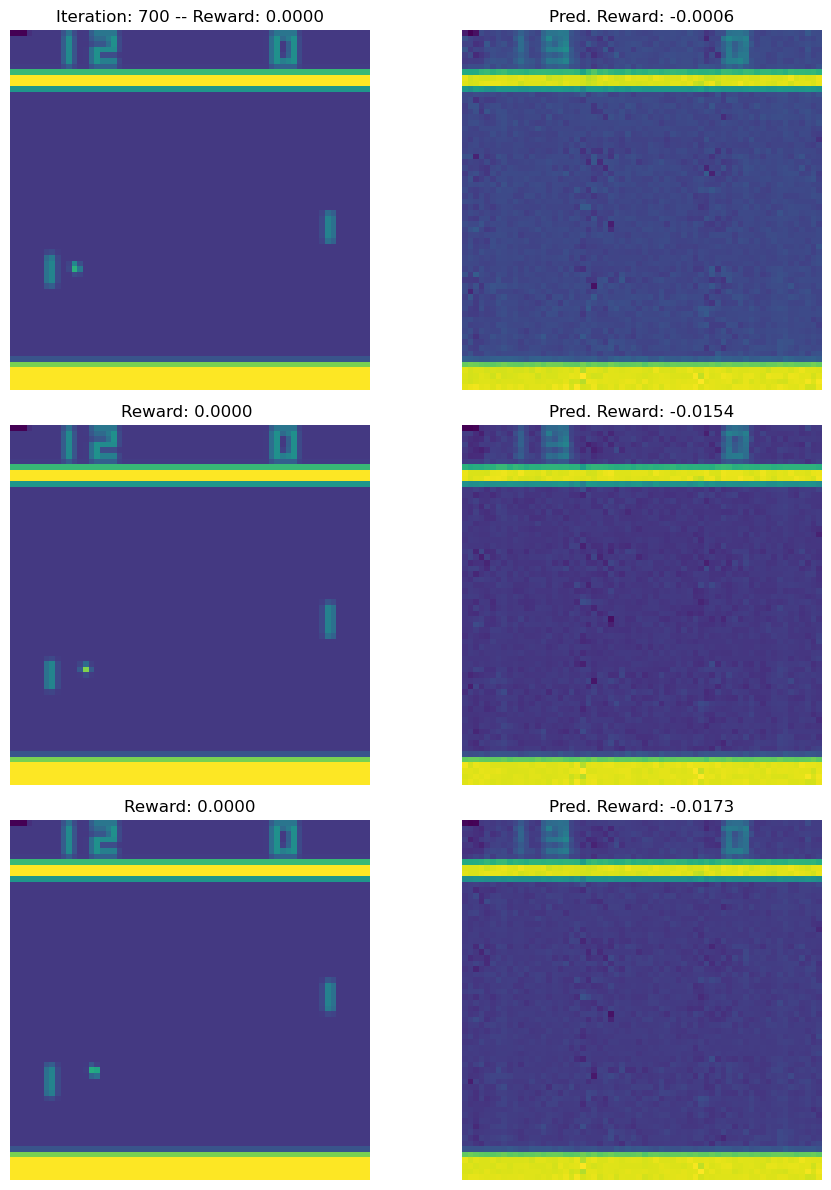

Epoch 8/10: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s, Total Loss=0.0229, Recon=0.0004, KL=0.0000, Reward=0.0225]


Epoch 8 completed. Average loss: 1270363403313660821504.0000


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

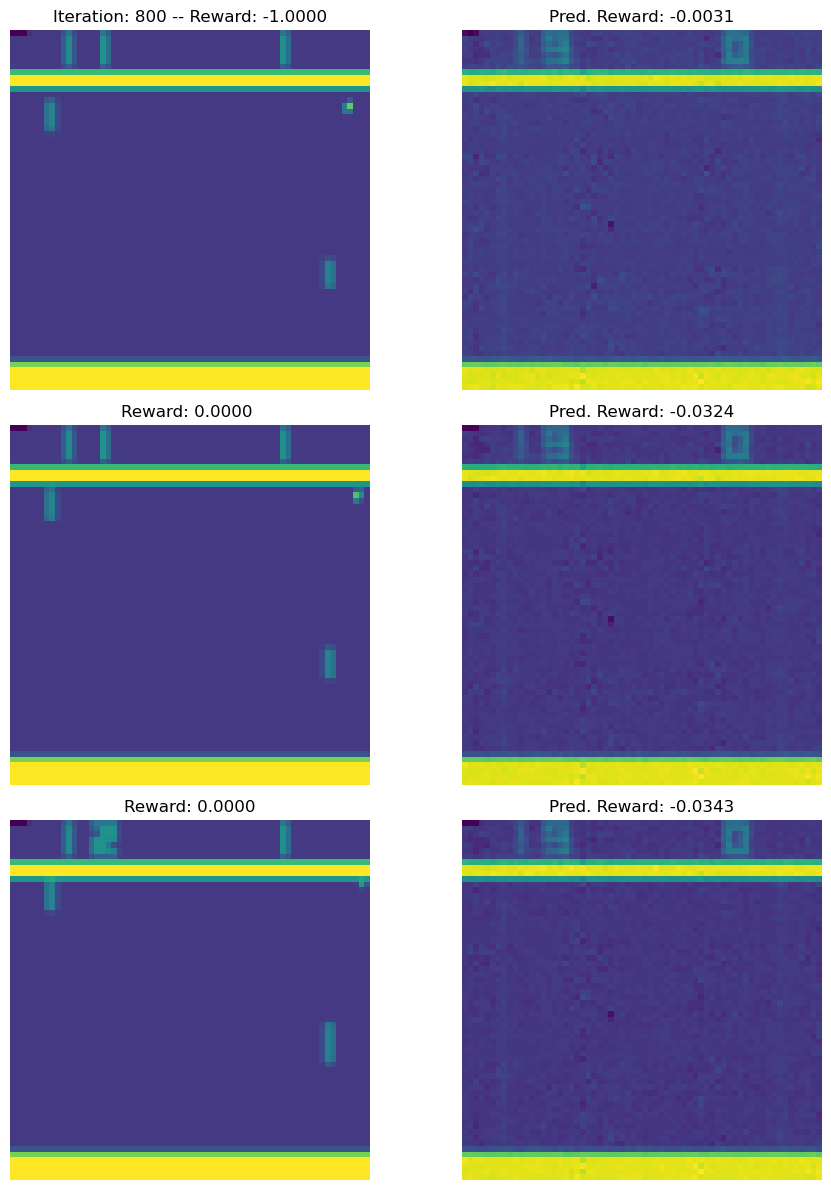

Epoch 9/10: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s, Total Loss=0.0215, Recon=0.0004, KL=0.0000, Reward=0.0211]


Epoch 9 completed. Average loss: 18536497999533277184.0000


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

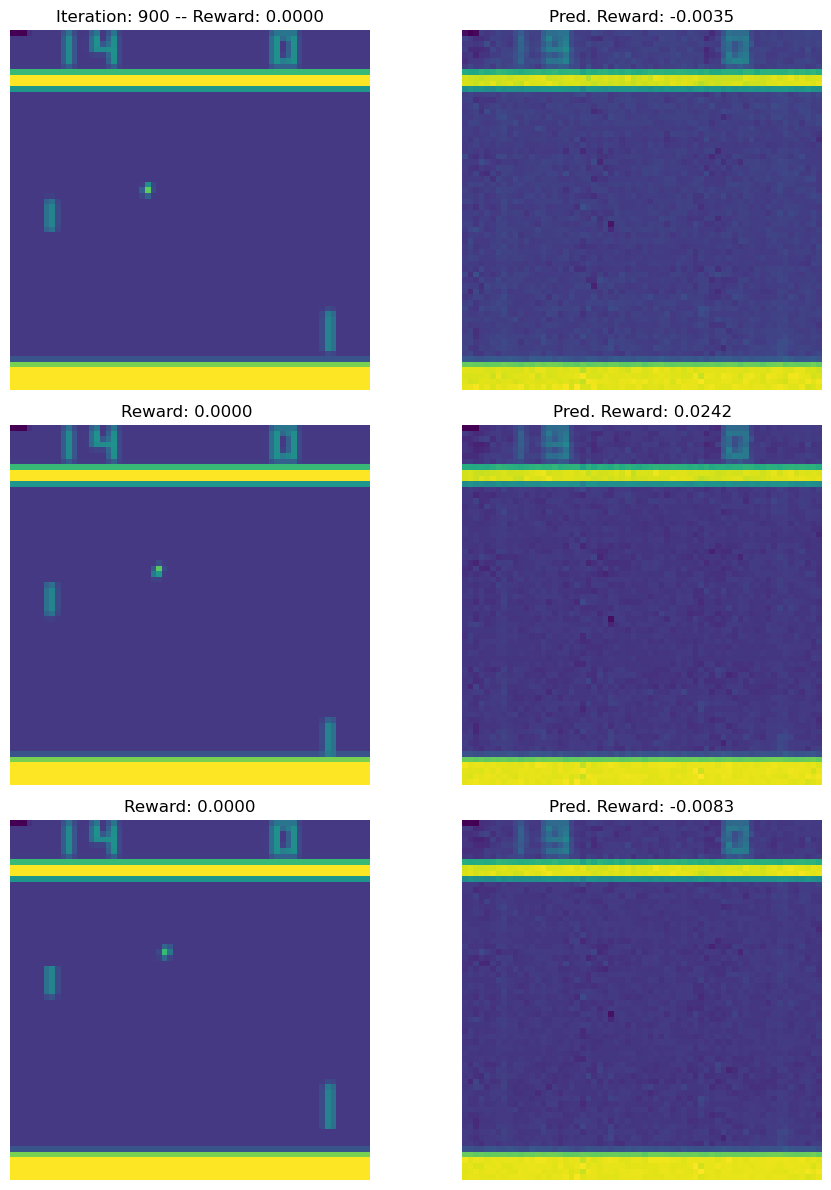

Epoch 10/10: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, Total Loss=0.0203, Recon=0.0004, KL=0.0000, Reward=0.0199]                                               

Epoch 10 completed. Average loss: 609373621330200448.0000
Training completed successfully!


In [58]:
atari_trainer = AtariTrainer(
    rssm=rssm,
    dataloader=dataloader,
    optimizer=optimizer,
    device=device,
)

print("AtariTrainer created successfully!")
print(f"Dataset size: {len(atari_dataset)} batches")
print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in rssm.parameters()):,} total")
print("\n Starting training...")

try:
    num_epochs = 10
    print(f"Training for {num_epochs} epochs...")
        
    atari_trainer.train(num_epochs)
    print("Training completed successfully!")
    
except Exception as e:
    print(f"Training failed: {e}")
    import traceback
    traceback.print_exc()